# Estimate Membership Activity

There are well-defined gaps in our logbooks, and logbooks largely inform the dataset's membership activity (e.g. subscriptions, renewals, etc.) Given those gaps, how accurately can we predict membership activity over a given time interval?

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import date, timedelta, datetime
import sklearn.metrics as metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from dateutil.parser import parse as date_parse
%matplotlib inline

# Prepare dataset

In [2]:
events_df = pd.read_csv(
    'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv',
    parse_dates=['start_date']
)

In [3]:
# Only select membership activity events that are sourced by the logbooks
# Select only the columns that are immediately useful
df = events_df[
    events_df.item_uri.isna() &
    events_df.source_type.str.contains('Logbook')
][[
    'member_names',
    'event_type', 'start_date', 'end_date', 
   'subscription_duration', 'subscription_duration_days',
   'subscription_volumes', 'subscription_category',
   'source_type'
]].dropna(subset=['start_date'])

df['start_date'] = pd.to_datetime(df['start_date'])

# Determine Gaps in Logbooks

In [4]:
with open('logbook-dates.json') as f:
    logbook_dates = json.load(f)
    for d in logbook_dates:
        d['startDate'] = date_parse(d['startDate'])
        d['endDate'] = date_parse(d['endDate'])

logbook_gaps = []
skipped = []
for i, _ in enumerate(logbook_dates[1:-1]):
    start = logbook_dates[i]['endDate']
    end = logbook_dates[i+1]['startDate']
    interval = end - start
    interval_dict = { 'start': start, 'end': end, 'interval': interval.days }
    if interval.days > 12:
        logbook_gaps.append(interval_dict)
    else:
        skipped.append(interval_dict)
        
logbook_gaps

[{'start': datetime.datetime(1927, 12, 31, 0, 0),
  'end': datetime.datetime(1928, 3, 1, 0, 0),
  'interval': 61},
 {'start': datetime.datetime(1930, 1, 2, 0, 0),
  'end': datetime.datetime(1930, 6, 2, 0, 0),
  'interval': 151},
 {'start': datetime.datetime(1930, 7, 31, 0, 0),
  'end': datetime.datetime(1931, 1, 1, 0, 0),
  'interval': 154},
 {'start': datetime.datetime(1931, 2, 16, 0, 0),
  'end': datetime.datetime(1932, 9, 26, 0, 0),
  'interval': 588},
 {'start': datetime.datetime(1936, 12, 31, 0, 0),
  'end': datetime.datetime(1938, 2, 17, 0, 0),
  'interval': 413},
 {'start': datetime.datetime(1938, 5, 5, 0, 0),
  'end': datetime.datetime(1938, 10, 21, 0, 0),
  'interval': 169}]

In [5]:
# What are the gaps in the logbook that we'll be working with?
print(len(logbook_gaps))
for date_dict in logbook_gaps:
    print(f"{date_dict['start'].strftime('%B %d %Y')} to {date_dict['end'].strftime('%B %d %Y')} ({date_dict['interval']} days)")

6
December 31 1927 to March 01 1928 (61 days)
January 02 1930 to June 02 1930 (151 days)
July 31 1930 to January 01 1931 (154 days)
February 16 1931 to September 26 1932 (588 days)
December 31 1936 to February 17 1938 (413 days)
May 05 1938 to October 21 1938 (169 days)


In [6]:
# How many gaps weren't included because they were deemed too small?
print(len(skipped))
for date_dict in skipped:
    print(f"{date_dict['start'].strftime('%B %d %Y')} to {date_dict['end'].strftime('%B %d %Y')} ({date_dict['interval']} days)")

8
December 31 1923 to January 02 1924 (2 days)
October 29 1927 to November 02 1927 (4 days)
April 30 1928 to May 01 1928 (1 days)
December 31 1928 to January 02 1929 (2 days)
November 30 1929 to December 02 1929 (2 days)
February 06 1934 to February 09 1934 (3 days)
December 31 1934 to January 12 1935 (12 days)
December 28 1935 to January 02 1936 (5 days)


In [7]:
def get_closest_date(d, index):
    return min([[abs(index_d - d), index_d] for index_d in index], key=lambda x: x[0])[1]

def add_logbook_vspans(ax, df_g):
    for gap in logbook_gaps:
        ax.axvspan(get_closest_date(gap['start'], df_g.index), 
                   get_closest_date(gap['end'], df_g.index),
            color="gray", alpha=0.3)
    return ax


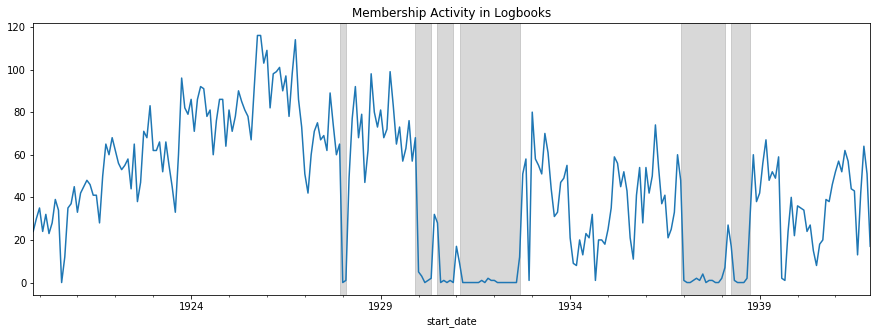

In [8]:
monthly_count = df.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
ax = monthly_count.plot(figsize=(15, 5))
ax.set_title('Membership Activity in Logbooks')
add_logbook_vspans(ax, monthly_count)

In [9]:
# How many membership events occur during the logbook gaps?
dfs = []
for gap in logbook_gaps:
    dfs.append(df[df['start_date'].between(gap['start'], gap['end'], inclusive=False)])
pd.concat(dfs).shape[0]

33

In [10]:
# Filter logbook gaps dates out of the dataset
for gap in logbook_gaps:
    df = df[~df['start_date'].between(gap['start'], gap['end'], inclusive=False)]

# Generate Features

In [11]:
def scale_year_data(series):
    MEAN = np.array(df_t.index.year.to_list()).mean()
    DIFF = df_t.max() - df_t.min()
    return (series - MEAN) / DIFF

df_t = df.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
df_t = df_t[df_t != 0]
month_categorical = pd.get_dummies(df_t.index.month, prefix='month_')
year_n = scale_year_data(df_t.index.year)

all_X = month_categorical.copy()
all_X['year_n'] = year_n
all_y = df_t.values

# Train and test model

In [12]:
# Run train / test split 3 times
for random_seed in range(3):
    X_train, X_test, y_train, y_test = train_test_split(
        all_X, all_y, test_size=0.33, random_state=random_seed)

    regr = svm.SVR()
    model = regr.fit(X_train, y_train)
    print('------- TEST -------')
    test_MAE = metrics.mean_absolute_error(y_test, model.predict(X_test))
    print(f'MAE: {round(test_MAE, 4)}')
    print('------- TRAIN -------')
    print(f'MAE: {round(metrics.mean_absolute_error(y_train, model.predict(X_train)), 4)}\n')

------- TEST -------
MAE: 22.1207
------- TRAIN -------
MAE: 20.3414

------- TEST -------
MAE: 19.3657
------- TRAIN -------
MAE: 21.5454

------- TEST -------
MAE: 21.3901
------- TRAIN -------
MAE: 20.6282



# Fit logbook gaps into monthly model

Logbook gaps are not exactly a month long, of course, so we'll need to extend the gaps so that we can properly fit them into our linear model.

In [13]:
def round_month(d):
    if d.day >= 17:
        return add_month(d)
    return date(d.year, d.month, 1)

def add_month(d):
    year = d.year
    month = d.month + 1
    if month == 13:
        year += 1
        month = 1
    return date(year, month, 1)

def round_gaps_to_months(d):
    month_list = []
    start_month = round_month(d['start'])
    end_month = round_month(d['end'])
    while start_month < end_month:
        month_list.append(start_month)
        start_month = add_month(start_month)
    return month_list

months_to_predict = []
for gap in logbook_gaps:
    months_to_predict.extend(round_gaps_to_months(gap))

In [14]:
# How many events are removed so that it can fit cleanly into monthly prediction model?
monthly_count = pd.DataFrame(
    df.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
)

monthly_count['day_setter'] = pd.to_datetime(monthly_count.index)
monthly_count.index = monthly_count['day_setter'].apply(lambda x: datetime(x.year, x.month, 1))
monthly_count = monthly_count.drop(columns=['day_setter'])

monthly_count.index.name = 'month'
monthly_count.rename(columns={'event_type': 'membership_activity_count'})

monthly_count.loc[months_to_predict].sum()

event_type    62
dtype: int64

# Make predictions

In [15]:
def generate_pred_row(month_to_predict):
    d = {}
    for i in range(1, 13):
        if i == month_to_predict.month:
            d[f'month_{i}'] = 1
        else:
            d[f'month_{i}'] = 0
    d['year_n'] = scale_year_data(month_to_predict.year)
    return d

X_pred_l = []
for month_to_predict in months_to_predict:
    X_pred_l.append(generate_pred_row(month_to_predict))
X_pred = pd.DataFrame(X_pred_l)

In [16]:
predictions = model.predict(X_pred).round()
monthly_count_pred = monthly_count.copy()
monthly_count_pred.loc[months_to_predict] = predictions

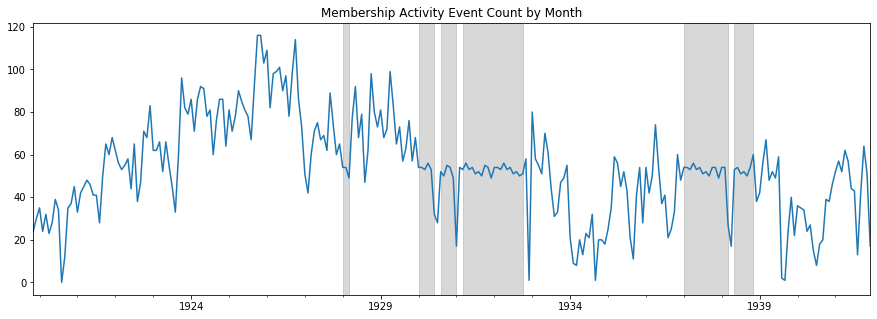

In [17]:
ax = monthly_count_pred.plot(figsize=(15, 5), legend=None, title='Membership Activity Event Count by Month')
ax.set_xlabel('')
add_logbook_vspans(ax, monthly_count)

## Generate Prediction CSV

In [18]:
df_t = pd.DataFrame([months_to_predict, predictions]).T
df_t.columns = ['month', 'predictions']
df_t.to_csv('output/membership-activity-predictions.csv', index=False)


# Summary

In [19]:
# How many months were filled in by the model?
len(months_to_predict)

52

In [20]:
# How many membership activity events are in the logbooks without the model
monthly_count.sum()

event_type    11531
dtype: int64

In [21]:
# How many membership activity events are in the entire dataset without the model?
dataset_total = events_df[events_df.item_uri.isna()].shape[0]
dataset_total

12552

In [22]:
# How many additional events are estimated by the model?
monthly_count_pred.sum()

event_type    14221.0
dtype: float64

In [23]:
# What proportion of membership activity events in the logbook do expect to have
round(monthly_count.sum() / monthly_count_pred.sum() * 100, 2)

event_type    81.08
dtype: float64

In [24]:
# What proportion of membership activity events can we suspect that we have?
round(dataset_total / monthly_count_pred.sum() * 100, 2)

event_type    88.26
dtype: float64